# When will the haunt begin?

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

## Betrayal!

One of the favorite board games at my house is [Betrayal at House on the Hill](https://en.wikipedia.org/wiki/Betrayal_at_House_on_the_Hill).

A unique feature of the game is the dice, which yield three possible outcomes, 0, 1, or 2, with equal probability.
When you add them up, you get some unusual probability distributions.

There are two phases of the game: During the first phase, players explore a haunted house, drawing cards and collecting items they will need during the second phase, called "The Haunt", which is when the players battle monsters and (usually) each other.

So when does the haunt begin?  It depends on the dice.  Each time a player draws an "omen" card, they have to make a "haunt roll": they roll six dice and add them up; if the total is less than the number of omen cards that have been drawn, the haunt begins.

For example, suppose four omen cards have been drawn.  A player draws a fifth omen card and then rolls six dice.  If the total is less than 5, the haunt begins.  Otherwise the first phase continues.

Last time I played this game, I was thinking about the probabilities involved in this process.  For example:

1. What is the probability of starting the haunt after the first omen card?

2. What is the probability of drawing at least 4 omen cards before the haunt?

3. What is the average number of omen cards before the haunt?

In this notebook, I'll compute the answers to these questions using `empiricaldist`, which is a Python library I wrote for working with discrete probability distributions.

In [18]:
# If we're running in Colab, install empiricaldist

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [19]:
import matplotlib.pyplot as plt

from empiricaldist import Pmf

## Three-sided dice?

First I'll make a `Pmf` that represents the outcome of a single die.

In [20]:
d3 = Pmf.from_seq([0, 1, 2])
d3

,probs
0,0.333333
1,0.333333
2,0.333333


A `Pmf` is a Pandas Series with some additional methods, like `add_dist`, which we can use to compute the distribution of the sum of two dice.

In [21]:
two = d3.add_dist(d3)
two

,probs
0,0.111111
1,0.222222
2,0.333333
3,0.222222
4,0.111111


And here's the distribution of the sum of six dice.

In [5]:
six = two.add_dist(two).add_dist(two)
six

,probs
0,0.001372
1,0.008230
2,0.028807
3,0.068587
4,0.123457
5,0.172840
6,0.193416
7,0.172840
8,0.123457
9,0.068587


The range of values is almost the same as the sum of two six-sided dice, but the shape of the distribution is a bit different.

In [22]:
d6 = Pmf.from_seq([1,2,3,4,5,6])

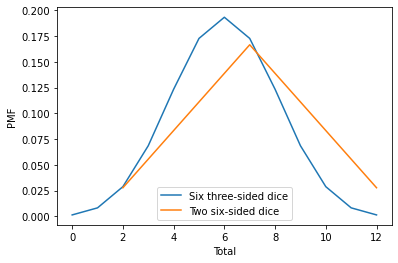

In [23]:
six.plot(label='Six three-sided dice')
d6.add_dist(d6).plot(label='Two six-sided dice')

plt.xlabel('Total')
plt.ylabel('PMF')
plt.legend();

When we add up more dice, the distribution of the sum looks more like a normal distribution.

## Conditional probability

We can use this `Pmf` to compute the conditional probability that the haunt begins for a given number of omen cards.

For example, if there are 5 omen cards, the probability that the haunt begins is the probability of rolling less than 5.

If we convert the `Pmf` to a `Cdf`, the result is almost what we want, but the `Cdf` is the probability of rolling less than *or equal to* the number of omen cards.

We can fix that by subtracting off the `Pmf`, like this. 

In [8]:
prob_haunt = six.make_cdf() - six
prob_haunt

0     0.000000
1     0.001372
2     0.009602
3     0.038409
4     0.106996
5     0.230453
6     0.403292
7     0.596708
8     0.769547
9     0.893004
10    0.961591
11    0.990398
12    0.998628
dtype: float64

We can check the result by confirming that the probability of the haunt after 1 omen card is the same as the probability of rolling 0.

In [9]:
prob_haunt[1], six[0]

(0.0013717421124828533, 0.0013717421124828531)

## The hazard function

What we just computed is a hazard function; that is, it contains the risk, or hazard, of failing the haunt roll after each omen card.

So we can take the values we just computed and put them in a `Hazard` object.

In [24]:
from empiricaldist import Hazard

haz = Hazard(prob_haunt)
haz

,probs
0,0.000000
1,0.001372
2,0.009602
3,0.038409
4,0.106996
5,0.230453
6,0.403292
7,0.596708
8,0.769547
9,0.893004


Actually, this isn't quite right.  To be complete, we have to add one more element: if there are 13 omen cards, the probability of starting the haunt is 1.

In [25]:
haz[13] = 1

Here's what the hazard function looks like.

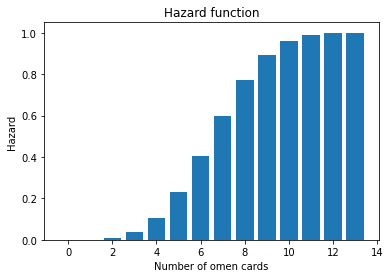

In [27]:
haz.bar()

plt.xlabel('Number of omen cards')
plt.ylabel('Hazard')
plt.title('Hazard function');

## The PMF

A `Hazard` function is one of several equivalent ways to represent a distribution, like a `Pmf` or `Cdf`.

Given the `Hazard` function, we can compute the `Pmf` like this:

In [28]:
pmf = haz.make_pmf()

And here's what it looks like:

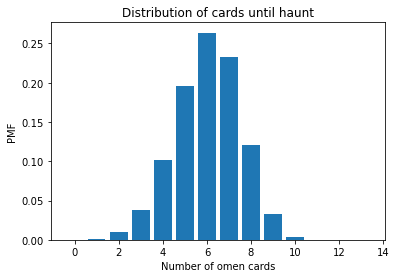

In [29]:
pmf.bar()

plt.xlabel('Number of omen cards')
plt.ylabel('PMF')
plt.title('Distribution of cards until haunt');

This `Pmf` represents the distribution of omen cards until the haunt.  The most likely value is 6.

In [30]:
pmf[6]

0.26358009196531695

So the probability is about 26% that the haunt begins after the sixth omen card.

And that's pretty close to the mean:

In [31]:
pmf.mean()

6.029128281158166

The most likely values are between 4 and 8.

In [32]:
pmf[4:9]

4    0.101759
5    0.195722
6    0.263580
7    0.232711
8    0.121035
dtype: float64

The total probability of those values is more than 90%.

In [33]:
pmf[4:9].sum()

0.9148057790379752

So when the haunt begins, it's unlikely that the players will have fewer than 4 omen cards, or more than 8.

The probability that the haunt starts after one omen card is small.

In [34]:
pmf[1]

0.00137174211248281

But the probability of making it all the way to 13 cards is even smaller.

In [36]:
pmf[13]

1.961989348764348e-09